# Davidson Dataset Hate Speech Detection

## Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer()
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import nltk
from nltk.corpus import stopwords
""" import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context """

nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wnl = WordNetLemmatizer()

import re
import numpy as np

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:1007)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:1007)>


Data definition:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [2]:
david_df = pd.read_csv('data/davidson.csv')
david_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## EDA and Preprocess definitions

There are no null values in the dataset

In [3]:
david_df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [4]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['tweet'] = df['tweet'].apply(lambda x: x.lower()) #lowercase
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    return df

In [5]:
def tokenize(df):
    df['tweet'] = tokenizer.texts_to_sequences(df['tweet'])
    vocab_size = len(tokenizer.word_index) + 1
    return df, vocab_size
def preprocess(df):
    df = clean(df)
    df, vocab_size = tokenize(df)
    return df, vocab_size

## Splitting the dataset and calling preprocessing functions

1. Tokenizer is fit on the training data only, which is used to transform both the training and test data to maintain the integrity of the val set as truly unseen data. This avoids data leakage.

In [6]:
X = david_df.drop(columns=['class'])
Y = david_df['class']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)
#X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.125, random_state=54) # 0.125 x 0.8 = 0.1
print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape) 
#print("Test Shape:", X_test.shape)

Training Shape: (19826, 6)
Validation Shape: (4957, 6)


Even after splitting the dataset, the distribution, although imbalanced, remains more or less consistent throughout original, train, val and test dataset. Hence, this splitting is correct.

<Figure size 640x480 with 0 Axes>

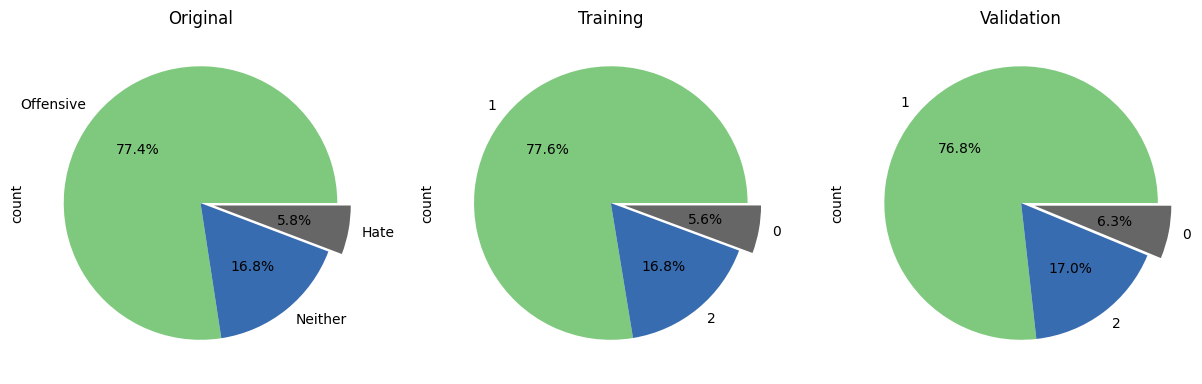

In [7]:
plt.suptitle('Class Distribution')
plt.figure(figsize=(15, 5))
explode = (0, 0, 0.1)
plt.subplot(1, 3, 1)
david_df['class_labels'] = david_df['class'].map({0: 'Hate', 1: 'Offensive', 2: 'Neither'})
david_df['class_labels'].value_counts().plot(kind='pie', title='Original', colormap='Accent', 
                                      autopct='%1.1f%%',
                                      explode=explode,
                                      )
plt.subplot(1, 3, 2)
Y_train.value_counts().plot.pie(title='Training', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.subplot(1, 3, 3)
Y_val.value_counts().plot.pie(title='Validation', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.show()
david_df.drop(columns=['class_labels'], inplace=True)

In [8]:
tokenizer.fit_on_texts(X_train['tweet'])
X_train, vocab_size = preprocess(X_train)
X_val, vocab_size = preprocess(X_val)
MAX_SEQ_LEN = 25
print("Maximum sequence length is approximated from here:",max(X_train['tweet'].apply(len)))
#X_test, vocab_size = preprocess(X_test)
X_train.head()

Maximum sequence length is approximated from here: 25


,Unnamed: 0,count,hate_speech,offensive_language,neither,tweet
1679,1714,3,0,3,0,"[11378, 2, 98, 21, 2, 98, 1226, 11380]"
5545,5703,3,0,0,3,"[2078, 98, 57, 203, 57, 416, 5637]"
18268,18674,3,0,3,0,"[4, 2078, 11381, 229, 229, 229, 2, 3778, 300, ..."
198,200,3,0,3,0,"[2078, 11383, 411, 1916, 3780, 435, 983, 204, ..."
22855,23334,3,1,2,0,"[2, 722, 52, 277, 11387, 163, 397, 1145]"


In [9]:
train_padded_tweet = tf.keras.preprocessing.sequence.pad_sequences(X_train['tweet'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)
val_padded_tweet = tf.keras.preprocessing.sequence.pad_sequences(X_val['tweet'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)
#test_padded_tweet = tf.keras.preprocessing.sequence.pad_sequences(X_test['tweet'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)

In [10]:
scaler = StandardScaler()
train_add_features = X_train[['count', 'hate_speech', 'offensive_language', 'neither']].values
val_add_features = X_val[['count', 'hate_speech', 'offensive_language', 'neither']].values
#test_add_features = X_test[['count', 'hate_speech', 'offensive_language', 'neither']].values

train_add_features_scaled = scaler.fit(train_add_features).transform(train_add_features)
val_add_features_scaled = scaler.transform(val_add_features)
#test_add_features_scaled = scaler.fit(test_add_features).transform(test_add_features)

In [11]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)
#Y_test_encoded = tf.keras.utils.to_categorical(Y_test, num_classes=3)

## Baseline Models: Simple_RNN, LSTM and GRU

In [12]:
BATCH_SIZE = 128
learning_rate = 0.0001

In [13]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_length)(text_input)
    x = LSTM(500, return_sequences=True)(x)
    x = dropout(0.8)(x)
    x = LSTM(300, return_sequences=True)(x)
    x = dropout(0.8)(x)
    x = LSTM(150)(x)
    x = dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = simpleRNN(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = GRU(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def train(model, X_train, Y_train, X_val, Y_val, epochs=25, batch_size=BATCH_SIZE):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)
    model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val), 
          epochs=epochs, batch_size=64, 
          class_weight=class_weights,
          callbacks=callback,
          verbose=1)
    print("\n\n****************************\n\n")
    print("Model trained successfully")
    pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
    #print("Predictions: ", np.round(pred, decimals=2))
    print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
    return model

In [17]:
m = model_LSTM(vocab_size)
model = train(m, train_padded_tweet, Y_train_encoded, val_padded_tweet, Y_val_encoded, epochs=5, batch_size=16)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - accuracy: 0.5882 - loss: 0.9131 - val_accuracy: 0.8281 - val_loss: 0.4959
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 243ms/step - accuracy: 0.8177 - loss: 0.5555 - val_accuracy: 0.8370 - val_loss: 0.5351
Epoch 3/5
292/310 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.8698 - loss: 0.4296

In [ ]:
m = model_RNN(vocab_size, input_length=MAX_SEQ_LEN)
model = train(m, train_padded_tweet, Y_train_encoded, val_padded_tweet, Y_val_encoded, epochs=5, batch_size=128)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5608 - loss: 0.9693 - val_accuracy: 0.7757 - val_loss: 0.6461
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7915 - loss: 0.5371 - val_accuracy: 0.7817 - val_loss: 0.5758
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8294 - loss: 0.3865 - val_accuracy: 0.7517 - val_loss: 0.6260
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8669 - loss: 0.2792 - val_accuracy: 0.8322 - val_loss: 0.4599
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9034 - loss: 0.2098 - val_accuracy: 0.8330 - val_loss: 0.4833


****************************


Model trained successfully
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8245 - loss: 0.4792
Validation Accuracy:  [0.4599495530128479, 0.8321565389633179]


In [ ]:
m = model_GRU(vocab_size, input_length=MAX_SEQ_LEN)
model = train(m, train_padded_tweet, Y_train_encoded, val_padded_tweet, Y_val_encoded, epochs=5, batch_size=128)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.3233 - loss: 1.0969 - val_accuracy: 0.7678 - val_loss: 1.0728
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.4232 - loss: 1.0999 - val_accuracy: 0.0625 - val_loss: 1.1041
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.3628 - loss: 1.0849 - val_accuracy: 0.1699 - val_loss: 1.0926
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.2499 - loss: 1.1142 - val_accuracy: 0.7426 - val_loss: 1.0817


****************************


Model trained successfully
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7653 - loss: 1.0729
Validation Accuracy:  [1.0727709531784058, 0.7678031325340271]
